## Set-up and Data Loading

In [1]:
from sentence_transformers import SentenceTransformer, util, models
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
import os
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from bertopic.representation import MaximalMarginalRelevance
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm.auto import tqdm
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
# from octis.evaluation_metrics.diversity_metrics import TopicDiversity

C:\Users\dathn\anaconda3\envs\thesis_v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_data = '..\\data_structured'

In [3]:
path_reports = '..\\data\\reports'

In [4]:
sample = os.listdir(path_reports)
# converting to panda series because I find it easier to manipulate
company_list = [word.split('.')[0] for word in sample]
company_list = pd.Series(company_list)
publisher_list = company_list.str.replace('-',' ') #so make it two words
publisher_list = publisher_list.str.replace('ford motor', 'ford')
publisher_list = publisher_list.str.replace('p&g', 'procter')
publisher_list

0            abb
1         adidas
2         airbus
3          apple
4          bayer
         ...    
58        toyota
59        veolia
60    volkswagen
61         volvo
62       walmart
Length: 63, dtype: object

In [5]:
names_list = publisher_list.tolist()

In [6]:
names_list.append('p&g')

In [7]:
names_list

['abb',
 'adidas',
 'airbus',
 'apple',
 'bayer',
 'beiersdorf',
 'blackrock',
 'bmw',
 'boeing',
 'cemex',
 'chevron',
 'chipotle',
 'citi',
 'coca cola',
 'colgate',
 'danone',
 'dell',
 'dhl',
 'diageo',
 'dupont',
 'edp',
 'enel',
 'eversource',
 'exxon',
 'ford',
 'general mills',
 'google',
 'h&m',
 'henkel',
 'hershey',
 'honda',
 'hp',
 'hyundai',
 'ibm',
 'inditex',
 'intel',
 'komatsu',
 'linde',
 'mcdonald',
 'mercedes',
 'microsoft',
 'mitsubishi',
 'mondelez',
 'nestle',
 'nextera',
 'nike',
 'procter',
 'pepsico',
 'ralph lauren',
 'renault',
 'rio tinto',
 'schneider electric',
 'shell',
 'sonoco',
 'starbucks',
 'tesco',
 'tesla',
 'totalenergies',
 'toyota',
 'veolia',
 'volkswagen',
 'volvo',
 'walmart',
 'p&g']

In [ ]:
df_report = pd.read_csv(os.path.join(path_data,'report_sentences.csv'))
df_pdf = pd.read_csv(os.path.join(path_data,'article_sentences_pdf.csv'))
df_gnews = pd.read_csv(os.path.join(path_data,'article_sentences_gnews.csv'))
df_article = pd.concat([df_pdf,df_gnews])

In [ ]:
df_article.shape

In [ ]:
df_report.shape

In [ ]:
df_article.drop_duplicates(subset = ['sentence'], inplace = True)
df_article.reset_index(inplace = True, drop = True)

In [ ]:
## part of the extra step below
#df_combined = pd.concat([df_article, df_report])

In [ ]:
sent_embedder = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [ ]:
df_rep = df_report.copy()
df_art = df_article.copy()

In [ ]:
# function for generating embeddings (useful for testing out later):
def gen_embeddings(df,model):
    sentences = df['sentence'].tolist()
    return model.encode(sentences)

In [ ]:
%%time
# creating embeddings for the report sentences and storing them in a new column
df_rep['embeddings'] = list(gen_embeddings(df_rep,sent_embedder))

In [ ]:
%%time
df_art['embeddings'] = list(gen_embeddings(df_art, sent_embedder))

- now we test out BERTopic 
- gonna try it with the overlapped sentence embeddings, non-overlapped?, and climateBERT + potentially FINbert
- then we try to manipulate the different parameters - tuning?

In [ ]:
df_rep.to_pickle(os.path.join(path_data,'rep.pkl'))
df_art.to_pickle(os.path.join(path_data,'art.pkl'))
# df_art = pd.read_pickle(os.path.join(path_data,'art.pkl'))
# df_rep = pd.read_pickle(os.path.join(path_data,'rep.pkl'))

In [ ]:
# combining the two datasets in preparation for the clustering
df_comb = pd.concat([df_art, df_rep])

In [ ]:
df_comb.shape

In [ ]:
df_comb['char_length'] = df_comb['sentence'].apply(lambda x: len(x))

In [ ]:
df_comb = df_comb[(df_comb['char_length'] > 20)]
df_comb.shape

In [ ]:
df_comb.drop_duplicates(subset = ['sentence'], inplace = True)
df_comb.shape

In [ ]:
import re
# Escaping the names_list for safe inclusion in the regular expression pattern
escaped_names = [re.escape(name) for name in names_list]

# Constructing the modified regular expression pattern
pattern = r"\b(?:{})(?:'s)?\b".format("|".join(escaped_names))

# Replace company names with 'company' using the regular expression pattern
df_comb['anon_sentence'] = df_comb['sentence'].str.replace(pattern, 'the company', case=False, regex=True)

# Print the modified dataframe
df_comb['anon_sentence'].values[200:260]

In [ ]:
df_comb.reset_index(inplace = True, drop = True)

In [ ]:
# Load the sentence embeddings and doc types from the dataframe
# embeddings = np.array(df_comb["embeddings"].tolist())

In [ ]:
# creating new embeddings based on the 'anonymized' sentences (without company names) - let's see how BERTopic handles it now
df_comb['anon_embeddings'] = list(gen_embeddings(df_comb, sent_embedder))

In [5]:
df_comb = pd.read_pickle(os.path.join(path_data, 'comb.pkl'))
# df_comb

## Visualizations

In [ ]:
# Create a histogram of the word count
plt.figure(figsize=(10,5))
plt.hist(df_comb['word count'], bins=30, color='skyblue')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('word_count_hist.png', dpi=300)

plt.show()

In [ ]:
# # Group the data by company, doc_type, and count the number of sentences
# df_by_company_doc_type = df_comb.groupby(['company', 'doc_type'])['sentence'].count().reset_index()

# # Pivot the dataframe to create separate columns for each doc_type
# df_pivot = df_by_company_doc_type.pivot(index='company', columns='doc_type', values='sentence')

# Create a line chart of the number of sentences by company and doc_type
plt.figure(figsize=(20,5));
df_pivot.plot.line(color=['red', 'blue'], marker='o', markersize=5)
plt.title('Number of Sentences by Company and Doc Type')
plt.xlabel('Company')
plt.ylabel('Number of Sentences')
plt.legend(title='Doc Type')

# Save the plot as a PNG file
plt.savefig('sentences_by_company_and_doc_type.png', dpi=300)
plt.show()

In [ ]:
umap2d = UMAP(n_components = 2, init = 'random', random_state = 0)
# umap3d = UMAP(n_components = 3, init = 'random', random_state = 0)

proj_2d = umap2d.fit_transform(embeddings)
# proj_3d = umap3d.fit_transform(embeddings)

In [ ]:
fig2d = px.scatter(
    proj_2d, x = 0, y = 1, 
    color = df_comb.doc_type, labels = {'color': 'doc_type'},
    width = 800, height = 500
)
# fig3d = px.scatter_3d(
#     proj_3d, x = 0, y = 1, z = 2,
#     color = df_comb.doc_type, labels = {'color': 'doc_type'}
# )

fig2d.show()
# fig3d.show()

In [ ]:
tsne2d = TSNE(n_components = 2, random_state = 0)
tsne3d = TSNE(n_components = 3, random_state = 0)

proj_2d_tsne = tsne2d.fit_transform(embeddings)
proj_3d_tsne = tsne3d.fit_transform(embeddings)


In [ ]:
fig2d_tsne = px.scatter(
    proj_2d_tsne, x = 0, y = 1, 
    color = df_comb.doc_type, labels = {'color': 'doc_type'}
)

# fig3d_tsne = px.scatter_3d(
#     proj_3d_tsne, x = 0, y = 1, z = 2,
#     color = df_comb.doc_type, labels = {'color': 'doc_type'}
# )

fig2d_tsne.show()
# fig3d_tsne.show()

Based on the above visualizations, we can see that unlike Boelders, we do not require to overlap the sentence embeddings over each other, as there are not large semantic differences between the news articles and the reports. The jargon and language seems to be mostly the same, as such we can just use the original embeddings.

## BERTopic Set-up

### Testing UMAP parameters

In [ ]:
colors = df_comb['doc_type']
c_map = {
    'news': '#FAFF00',
    'report': '#1C17FF'
}
colors = [c_map[x] for x in colors]
len(colors)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
nns = [5,10, 15, 30, 50, 100]
#2, 3, 4
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = UMAP(n_neighbors=n_neighbors, random_state = 0)
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1], ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

In [ ]:
fig.savefig('full_figure.png')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14))
nns = [3,4]
#2, 3, 4
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = UMAP(n_neighbors=n_neighbors, random_state = 0)
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1], c=colors, ax=ax[i])
    ax[i].set_title(f'n={n_neighbors}')
    i +=1

In [ ]:
fit = UMAP(n_neighbors=10, n_components=3, min_dist=0.0, init = 'random', metric = 'cosine', random_state = 0)
u = fit.fit_transform(embeddings)

# the lowest min distance finally creates some separation - what does increasing it do?

In [ ]:
fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=df_comb.doc_type,
    labels = {'color': 'doc_type'}
)

fig.show()

In [ ]:
# 2D representation
fit2d = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, init = 'random', metric = 'cosine', random_state = 0)
u2d = fit2d.fit_transform(embeddings)

fig2d = px.scatter(
    x=u2d[:,0], y=u2d[:,1],
    color=df_comb.doc_type,
    labels = {'color': 'doc_type'},
    width = 800, height = 500
)

fig2d.show()

In [ ]:
# 2D representation
fit2d = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, init = 'random', metric = 'cosine', random_state = 0)
u2d = fit2d.fit_transform(embeddings)

fig2d = px.scatter(
    x=u2d[:,0], y=u2d[:,1],
    color=df_comb.doc_type,
    labels = {'color': 'doc_type'},
    width = 800, height = 500
)

fig2d.show()

### Clustering with HDBSCAN

In [ ]:
clusterer = HDBSCAN(min_cluster_size = 400)
clusterer.fit(u)

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [ ]:
clusterer = HDBSCAN(min_cluster_size = 400, min_samples = 50, metric = 'euclidean')
clusterer.fit(u)
clusterer.condensed_tree_.plot(select_clusters=True)

## Running BERTopic

In [5]:
docs = df_comb['anon_sentence']

In [6]:
embeddings = np.array(df_comb["anon_embeddings"].tolist())

In [7]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0,init = 'random', metric = 'cosine', random_state = 0).fit_transform(embeddings)

In [13]:
# getting stopwords
stopwords = list(stopwords.words('english')) + ['company','coca','cola'] + names_list

In [14]:
# customizing parts of the BERTopic pipeline
# vectorizer
vectorizer_model = CountVectorizer(stop_words = stopwords)

# umap
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, init = 'random', metric = 'cosine', random_state = 0)

# hdbscan
hdbscan_model = HDBSCAN(min_cluster_size = 200, metric='euclidean', prediction_data=True)
# 200 has decent results
# min_samples
# diversity topic words
representation_model = MaximalMarginalRelevance(diversity=0.5)

In [ ]:
topic_model = BERTopic(
    embedding_model = sent_embedder,
    vectorizer_model = vectorizer_model,
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    language="english", 
    representation_model = representation_model, #diversify topic words
    calculate_probabilities=True, 
    verbose=True, 
    #nr_topics = 'auto'
    # min_topic_size = 50, 
    # n_gram_range = (1,2)
)
topics, probs = topic_model.fit_transform(docs, embeddings)

In [ ]:
def find_highest_probability(array):
    max_index = np.argmax(array)
    max_prob = array[max_index]
    return max_prob, max_index
find_highest_probability(probs[10])

In [ ]:
topic_model.get_topic_info()[:60]

In [ ]:
topic_model.get_topic_info()[:60]

In [ ]:
topic_model.visualize_barchart(top_n_topics=10, n_words = 10, height = 400)

In [ ]:
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

## Topic Reduction

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

In [ ]:
topic_model.get_topic(26)

In [ ]:
topic_model.get_representative_docs(26)

In [ ]:
>>> tree = topic_model.get_topic_tree(hierarchical_topics)
>>> print(tree)

# saf stands for sustainabile aviation fuel - together with topic 13 talks about the opportunities for sustainable fuel to reduce mostly emissions - can call it something like sustainable transportation? with dhl

In [ ]:
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)

In [ ]:
# Now reduction of topics - we will merge them manually based ont he above visualizations
topics_to_merge = [
    [20,33,3,14], #plastic packaging and recycling
    [12,4,7,51,60,24,59,30], #recycling, more focus on circular economy other than just plastic - include 59? (printing), 32 (sustainable materials/sourcing?)
    [58,56,35,21,13], #regenerative agriculture/sustainable agriculture
    [8,23,27], #water, biodiversity, deforestation - could be called nature preservation
    [43,16], #sustainability (tech) innovation
    #[5,28], #climate change
    [1,6,17,22], #sustainable leadership/governance?
    [29,11,25,19], #sustainable fuels/transportations
    [39,40,2,15,53,61,45,47,30,32], #decarbonisation,emission reductions - include 47? (air pollution), 30? (chemical substances)
    [18,34,46]#EV's
] 
topic_model.merge_topics(docs, topics_to_merge)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_representative_docs(25)

## Outlier Reduction

In [9]:
df_comb = pd.read_pickle(os.path.join(path_data,'comb.pkl'))

In [ ]:
topic_model.save('merged_model')

In [15]:
topic_model = BERTopic.load('merged_model')

In [16]:
topics = topic_model.topics_
probs = topic_model.probabilities_

In [20]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,64123,-1_emissions_sustainability_2021_climate
1,0,12313,0_sustainability_esg_strategy_impact
2,1,10383,1_offshore_mw_renewables_farm
3,2,10170,2_waste_recycling_circular_batteries
4,3,9618,3_emissions_scope_co2_ghg
5,4,7813,4_plastic_packaging_cola_bottles
6,5,4684,5_biodiversity_conservation_wastewater_forests
7,6,4105,6_hydrogen_saf_fuels_cell
8,7,3875,7_climate_change_risks_global
9,8,3494,8_cocoa_agriculture_regenerative_methane


In [17]:
%%time
#new_topics_probs = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")
#new_topics_tfidf = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf", threshold = 0.1)
new_topics_dist = topic_model.reduce_outliers(docs, topics, strategy = "distributions", threshold = 0.08)

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:13<00:00,  4.77it/s]


CPU times: total: 6.64 s
Wall time: 14.4 s


In [ ]:
new_topics_embed = topic_model.reduce_outliers(docs, topics, strategy = "embeddings", threshold = 0.23)

### HDBSCAN Probabilities

In [ ]:
topic_model.update_topics(docs, topics=new_topics_probs, vectorizer_model = vectorizer_model, representation_model = representation_model)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [ ]:
topic_model.get_topic_info()

### C-TF-IDF similarity

In [ ]:
topic_model.update_topics(docs, topics=new_topics_tfidf, vectorizer_model = vectorizer_model, representation_model = representation_model)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [ ]:
topic_model.get_topic_info()

### Using topic distributions

In [25]:
df_comb.shape

(144949, 9)

In [ ]:
topic_model.update_topics(docs, topics=new_topics_dist, vectorizer_model = vectorizer_model, representation_model = representation_model) #  representation_model = representation_model
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [22]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,15018,-1_de_new_oil_process
1,0,17687,0_sustainability_esg_impact_strategy
2,1,13164,1_offshore_projects_renewables_storage
3,2,13283,2_waste_recycling_circular_made
4,3,14038,3_emissions_scope_co2_reduce
5,4,10044,4_plastic_packaging_bottles_reusable
6,5,5597,5_biodiversity_conservation_deforestation_areas
7,6,5243,6_saf_fuels_sustainable_cell
8,7,6109,7_climate_global_risks_paris
9,8,5027,8_cocoa_agriculture_regenerative_practices


In [ ]:
# topic_model.set_topic_labels({0: "ESG governance", 1: "Renewable Energy", 2: "Waste Management", 3: "Emission Reduction", 4: "Plastics Recyling", 5: "Nature Preservation", 6:"Sustainable Transportation", 7: "Climate Change", 8: "Sustainable Agriculture", 9: "Stocks",
#                              10: "Electrical Vehicles", 12:"Sustainable Innovation", 14:"No Comment", })

In [ ]:
topics = topic_model.topics_
df_comb['topics'] = topics

In [ ]:
df_comb.to_pickle(os.path.join(path_data,'comb.pkl'))

In [ ]:
df_comb['topics'].value_counts()

In [ ]:
list(df_comb[df_comb['topics'] == 27]['anon_sentence'].values)

In [23]:
# second merging after taking a look at the reports
topics_to_merge = [
    [26,10], #green cars/car production
    [14,3], #pollution lawsuits included
    
] 
topic_model.merge_topics(docs, topics_to_merge)

In [24]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,15018,-1_de_new_oil_process
1,0,17687,0_sustainability_esg_impact_strategy
2,1,15932,1_emissions_scope_co2_reduce
3,2,13283,2_waste_recycling_circular_batteries
4,3,13164,3_offshore_renewables_storage_grid
5,4,10044,4_plastic_packaging_bottles_reusable
6,5,6196,5_charging_ev_trucks_hybrid
7,6,6109,6_climate_global_risks_paris
8,7,5597,7_biodiversity_conservation_deforestation_areas
9,8,5243,8_saf_fuels_sustainable_cell


In [ ]:
from wordcloud import WordCloud

def create_wordcloud(model, topic, save_path = None):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if save_path:
        plt.savefig(os.path.join(save_path, f"wordcloud_{topic}.png"))
    else:
        plt.show()


In [10]:
sust_topics = [0,1,2,3,4,5,6,7,8,10,11,20,25]
# save_path = ".\\visualizations"

# for i in sust_topics:
#     create_wordcloud(topic_model, i, save_path = save_path)

In [ ]:
text = {word: value for word, value in topic_model.get_topic(0)}

In [11]:
topic_labelling = {0: "ESG Governance", 1: "Emission Reduction", 2: "Waste Management", 3: "Renewable Energy", 4: "Plastics Recycling", 5: "Electrical Vehicles", 6:"Climate Change Risk Mitigation", 7: "Nature Conservation", 8: "Green Transportation",
                   10: "Sustainable Agriculture", 11:"Sustainable Innovation", 20:"Sustainable Finance", 25:"Greenwashing Accusations"}

In [12]:
df_analyze = df_comb[df_comb['topics'].isin(sust_topics)]
df_analyze.reset_index(inplace=True, drop = True)

In [13]:
df_analyze['topic_labels'] = df_analyze['topics'].apply(lambda x: topic_labelling[x])

In [14]:
df_analyze[(df_analyze['topic_labels']=='Greenwashing Accusations')&(df_analyze['doc_type'] =='report')].shape

(11, 10)

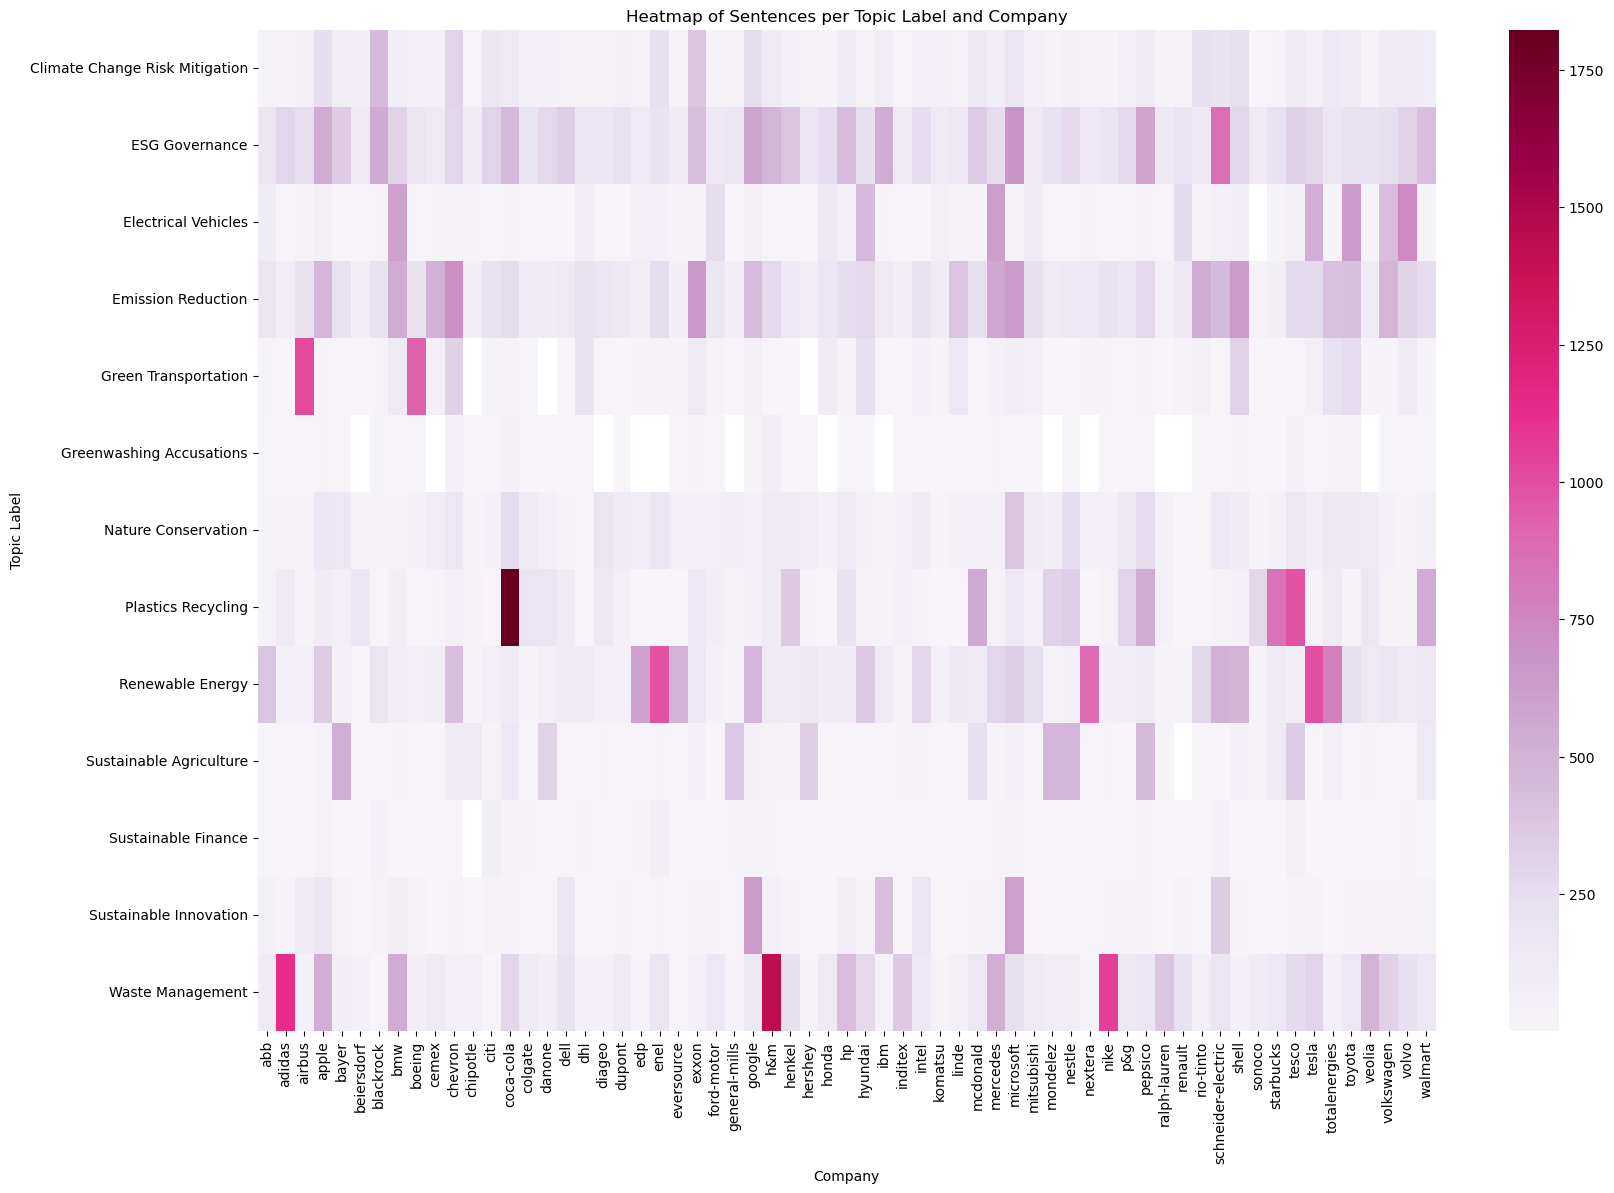

In [15]:
# Group the data by 'topic_labels' and 'company', and count the number of rows
df_counts = df_analyze.groupby(['topic_labels', 'company']).size().unstack()

# Create the heatmap
plt.figure(figsize=(19, 13))
sns.heatmap(df_counts, cmap='PuRd', annot=False)
plt.title('Heatmap of Sentences per Topic Label and Company')
plt.xlabel('Company')
plt.ylabel('Topic Label')

# Show the plot
plt.savefig('topic_heatmap.png', dpi=300)

plt.show()

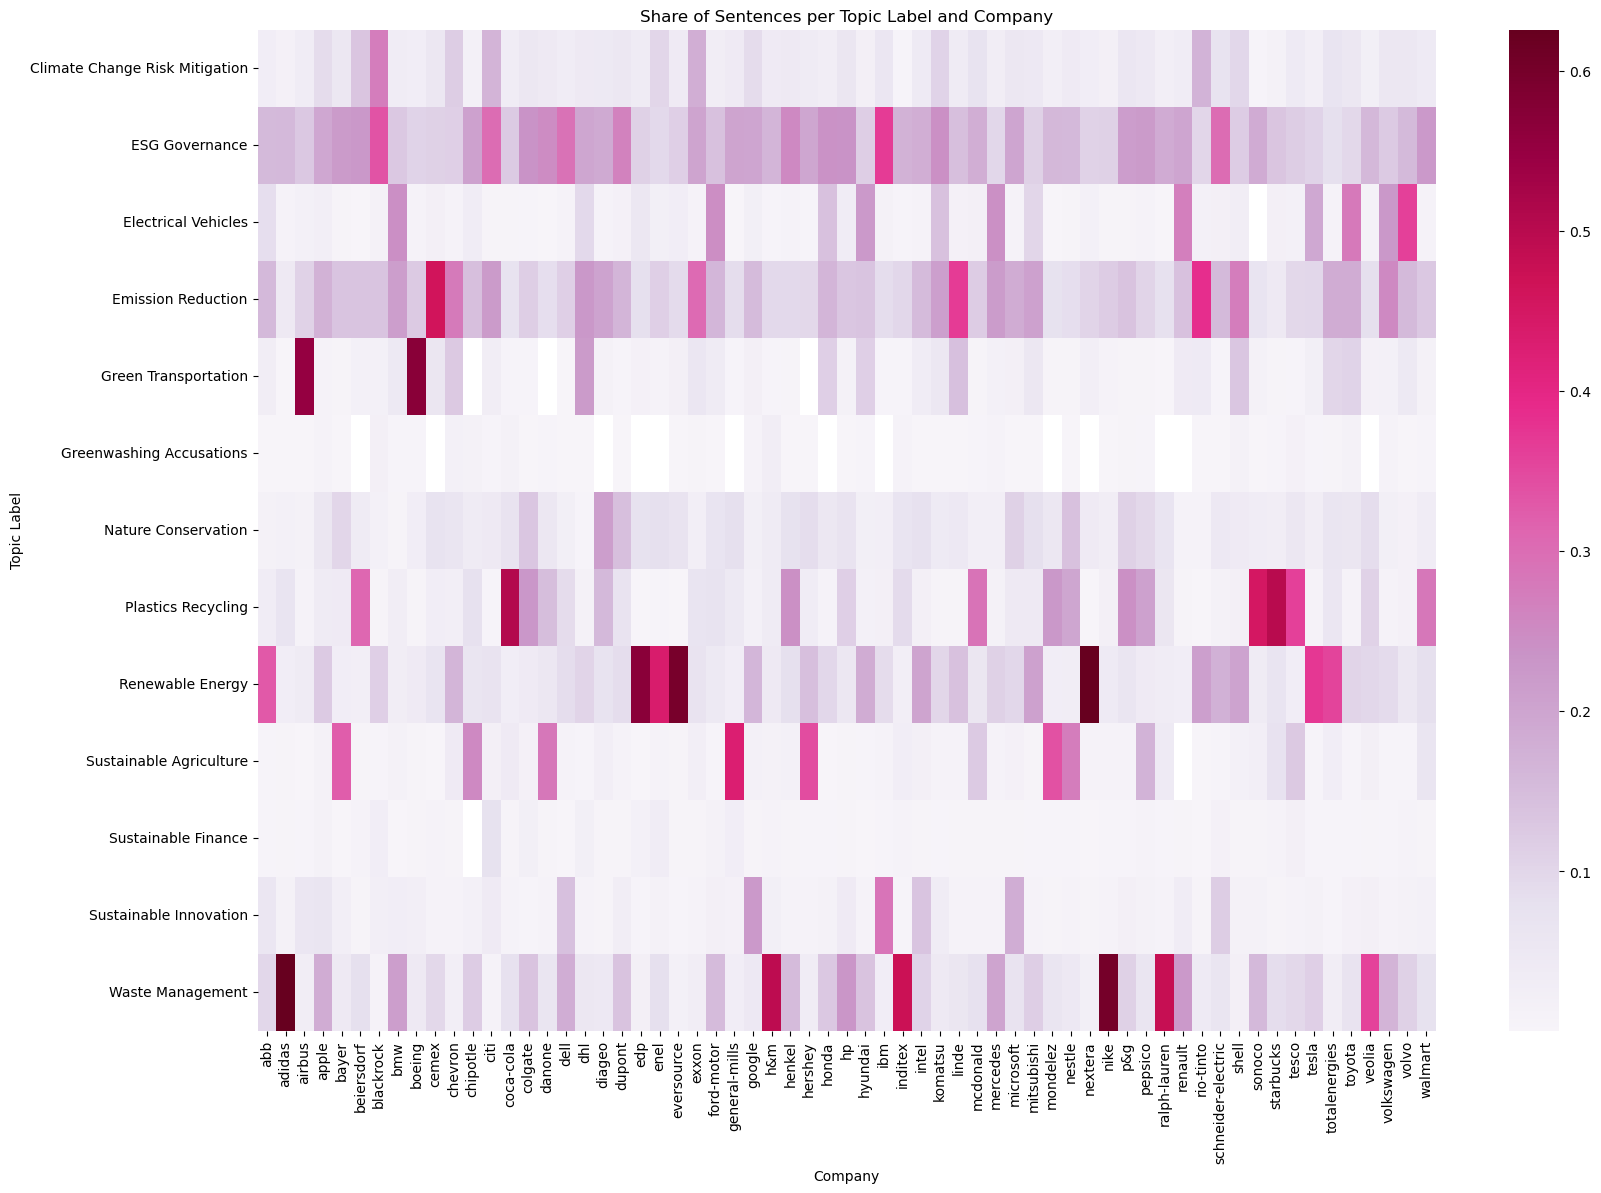

In [30]:
# Calculate the share of sentences per topic label and company
df_share = df_analyze.groupby(['company', 'topic_labels'])['sentence'].count() / df_analyze.groupby('company')['sentence'].count()
df_share = df_share.unstack().T

# Create the heatmap
plt.figure(figsize=(19, 13))
sns.heatmap(df_share, cmap='PuRd', annot=False)
plt.title('Share of Sentences per Topic Label and Company')
plt.xlabel('Company')
plt.ylabel('Topic Label')

# # Save the plot as a PNG file
plt.savefig('heatmap.png', dpi=500)

# Show the plot
plt.show()

### Using Sentence and Topic Embedding Similarity

In [ ]:
#topic_model.update_topics(docs, topics=new_topics_embed, vectorizer_model = vectorizer_model,representation_model = representation_model)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=False, hide_annotations=True)

In [ ]:
topic_model.get_topic_info()

## Fitting different embedding models

In [ ]:
# mpnet - don't have high hopes for this one
model_mpnet = SentenceTransformer('all-mpnet-base-v2')
mpnet_embeddings = gen_embeddings(len(df_comb), model_mpnet) 

np.save('mpnet_embeddings', mpnet_embeddings)

In [ ]:
len(clim_embeddings)

In [ ]:
topics_clim = topic_model.fit_transform(docs, clim_embeddings)

In [ ]:
topic_model.get_topic_info()

In [ ]:
reduced_clim_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0,init = 'random', metric = 'cosine', random_state = 0).fit_transform(clim_embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_clim_embeddings)

In [ ]:
topic_term_matrix = topic_model.c_tf_idf_
words = topic_model.vectorizer_model.get_feature_names_out()

In [ ]:
topic_words

## Calculating Coherence

In [ ]:
documents = pd.DataFrame({"Document": filtered_text,
                          "ID": range(len(filtered_text)),
                          "Topic": topics[0]})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics[0]))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [ ]:
coherence

In [ ]:
kmeans_model = KMeans(n_clusters = k, init = 'k-means++',random_state = 0, n_init = 10)

In [ ]:
topic_model = BERTopic(
    vectorizer_model = vectorizer_model,
    umap_model = umap_model,
    hdbscan_model = kmeans_model,
    language="english", 
    representation_model = representation_model, #diversify topic words
    calculate_probabilities=False, 
    verbose=True, 
    #nr_topics = 'auto'
    # min_topic_size = 50, 
    # n_gram_range = (1,2)
)
topics = topic_model.fit_transform(docs, embeddings)